Memuat dataset Fashion-MNIST...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Memulai pelatihan selama 20 epoch...
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - kl_loss: 4.3970 - loss: 396.5090 - reconstruction_loss: 392.1120
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.9808 - loss: 304.5612 - reconstruction_loss: 297.5804
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 7.3521 - loss: 277.7358 - reconstruction_loss: 270.3837
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 7.0033 - loss: 272.7630 - reconstruction_loss: 265.7597
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 6.7805 - loss: 270.4728 - reconstruction_loss: 263.6923
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.6457 - loss: 268.9521 - reconstruction_loss: 262.3065
Epoch 7/20
469/469 ━━━━━━━

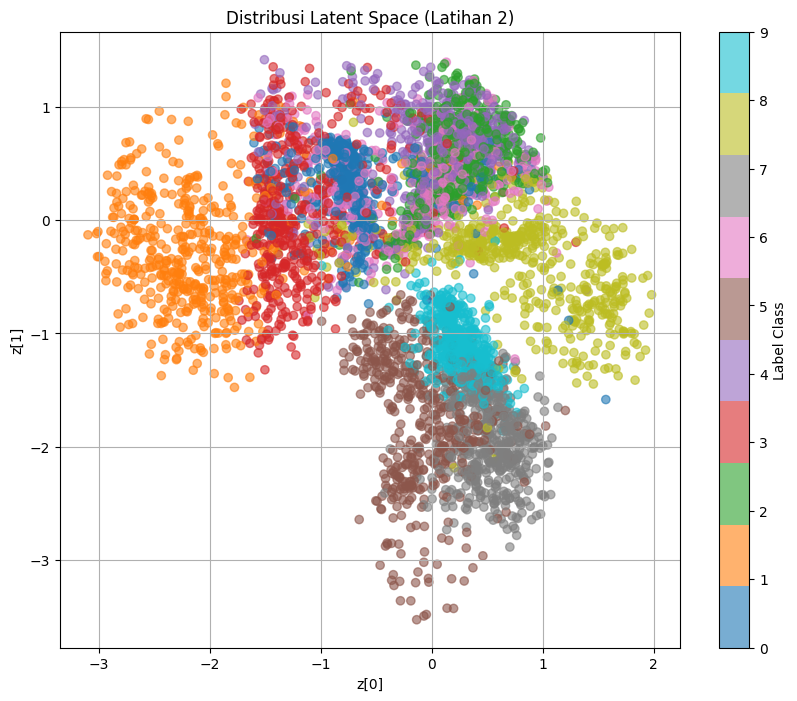

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


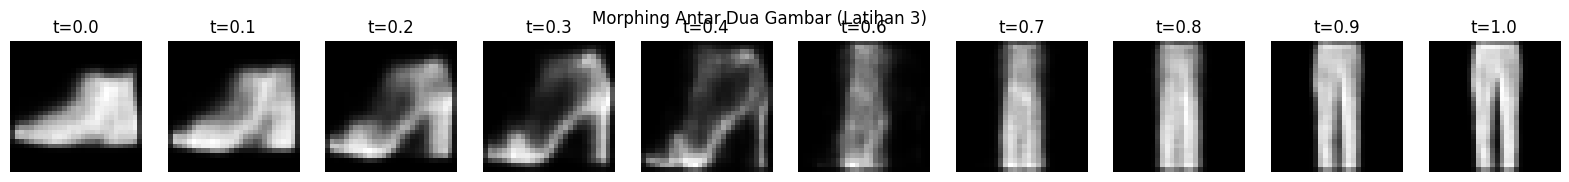

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


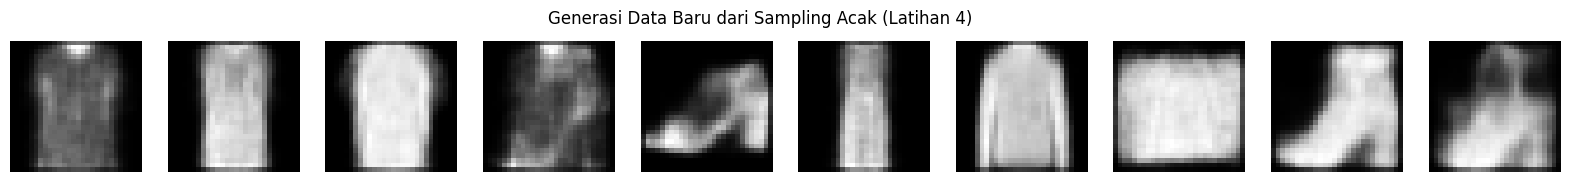

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


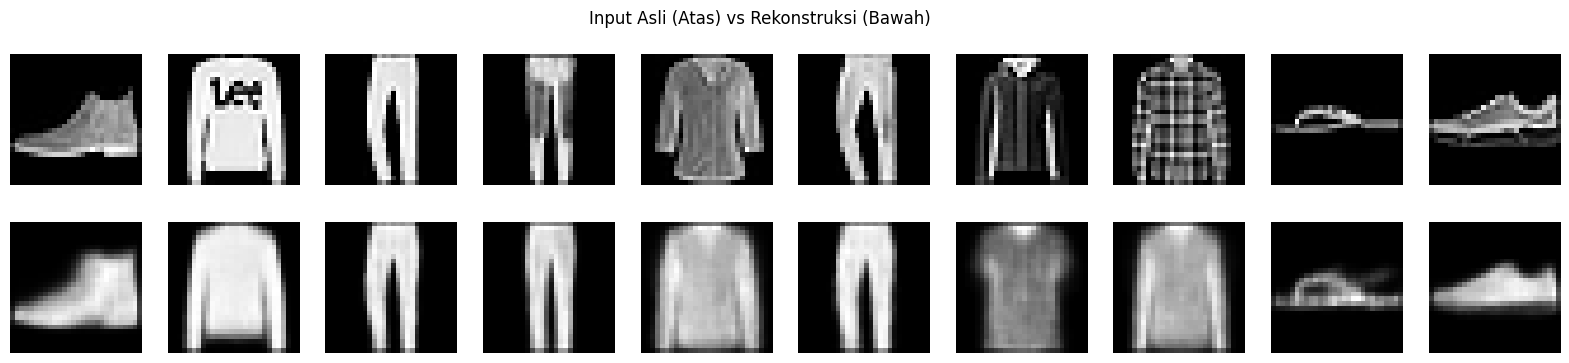

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ==========================================
# 1. PERSIAPAN DATA (Fashion-MNIST)
# ==========================================
print("Memuat dataset Fashion-MNIST...")
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalisasi data ke rentang [0, 1] dan reshape
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

# Nama label untuk visualisasi
label_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# ==========================================
# 2. ARSITEKTUR VAE
# ==========================================

# Layer Sampling untuk Reparameterization Trick
class Sampling(layers.Layer):
    """Menggunakan (z_mean, z_log_var) untuk sampling z."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Hiperparameter
latent_dim = 2 # Menggunakan 2 dimensi agar mudah divisualisasikan (Latihan 2)

# Encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Model VAE
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# ==========================================
# 3. TRAINING (Modifikasi Epoch ke 20)
# ==========================================
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

print("\nMemulai pelatihan selama 20 epoch...")
vae.fit(x_train, epochs=20, batch_size=128, verbose=1)

# ==========================================
# LATIHAN 2: VISUALISASI LATENT SPACE
# ==========================================
def plot_latent_space(vae, data, labels):
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap="tab10", alpha=0.6)
    plt.colorbar(scatter, ticks=range(10), label="Label Class")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Distribusi Latent Space (Latihan 2)")
    plt.grid(True)
    plt.show()

plot_latent_space(vae, x_test[:5000], y_test[:5000])

# ==========================================
# LATIHAN 3: LATENT SPACE ARITHMETIC (MORPHING)
# ==========================================
def plot_morphing(vae, img1_idx, img2_idx, n=10):
    # Ambil 2 gambar dari test set
    img1 = x_test[img1_idx : img1_idx + 1]
    img2 = x_test[img2_idx : img2_idx + 1]

    # Dapatkan representasi laten
    z1, _, _ = vae.encoder.predict(img1)
    z2, _, _ = vae.encoder.predict(img2)

    # Interpolasi linear antara z1 dan z2
    t_values = np.linspace(0, 1, n)
    z_interp = np.array([(1 - t) * z1 + t * z2 for t in t_values])
    z_interp = z_interp.reshape(n, latent_dim)

    # Decode hasil interpolasi
    reconstructions = vae.decoder.predict(z_interp)

    plt.figure(figsize=(n * 2, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(reconstructions[i].reshape(28, 28), cmap="gray")
        plt.title(f"t={t_values[i]:.1f}")
        plt.axis("off")
    plt.suptitle("Morphing Antar Dua Gambar (Latihan 3)")
    plt.show()

# Mencari indeks untuk T-shirt (label 0) dan Ankle Boot (label 9)
plot_morphing(vae, 0, 15, n=10)

# ==========================================
# LATIHAN 4: GENERASI DATA BARU
# ==========================================
def generate_new_data(vae, n=10):
    # Sampling z dari distribusi normal standar N(0, 1)
    random_latent_vectors = np.random.normal(size=(n, latent_dim))
    generated_images = vae.decoder.predict(random_latent_vectors)

    plt.figure(figsize=(n * 2, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.suptitle("Generasi Data Baru dari Sampling Acak (Latihan 4)")
    plt.show()

generate_new_data(vae, n=10)

# ==========================================
# REKONSTRUKSI AKHIR
# ==========================================
def plot_reconstruction(vae, n=10):
    imgs = x_test[:n]
    _, _, z = vae.encoder.predict(imgs)
    recons = vae.decoder.predict(z)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recons[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.suptitle("Input Asli (Atas) vs Rekonstruksi (Bawah)")
    plt.show()

plot_reconstruction(vae)
